# Setup

In [19]:
# required packages here
library(party)
library(tidyverse)
library(randomForest)

Warning message:
"package 'party' was built under R version 4.1.3"
Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Warning message:
"package 'strucchange' was built under R version 4.1.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.1.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Warning message:
"package 'sandwich' was built under R version 4.1.3"
Warning message:
"package 'tidyverse' was built under R version 4.1.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.1.3"

In [20]:
data <- read.csv("hotel_bookings.csv")
dim(data)

[1] 119390     32

In [21]:
head(data)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,...,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>
1,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NULL,NULL,0,Transient,0,0,0,Check-Out,2015-07-01
3,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NULL,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304,NULL,0,Transient,75,0,0,Check-Out,2015-07-02
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240,NULL,0,Transient,98,0,1,Check-Out,2015-07-03


In [22]:
str(data)

'data.frame':	119390 obs. of  32 variables:
 $ hotel                         : chr  "Resort Hotel" "Resort Hotel" "Resort Hotel" "Resort Hotel" ...
 $ is_canceled                   : int  0 0 0 0 0 0 0 0 1 1 ...
 $ lead_time                     : int  342 737 7 13 14 14 0 9 85 75 ...
 $ arrival_date_year             : int  2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 ...
 $ arrival_date_month            : chr  "July" "July" "July" "July" ...
 $ arrival_date_week_number      : int  27 27 27 27 27 27 27 27 27 27 ...
 $ arrival_date_day_of_month     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ stays_in_weekend_nights       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stays_in_week_nights          : int  0 0 1 1 2 2 2 2 3 3 ...
 $ adults                        : int  2 2 1 1 2 2 2 2 2 2 ...
 $ children                      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ babies                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ meal                          : chr  "BB" "BB" "BB" "BB" ...
 $ country                 

In [23]:
purple <- "#633ebb"
light_purple <- "#A85CF9"
red <- "#f13c59"
light_blue <- "#c6d1ff"
blue <- "#40DFEF"

beige <- "#fec57e"
colors <- c(light_purple, light_blue)

# Data Preprocessing

### Remove reservation status from data

In [24]:
data <- within(data, rm("reservation_status", "reservation_status_date"))
dim(data)

[1] 119390     30

### Changing values of Arrival date months to a smaller representation

In [25]:
data$arrival_date_month <- factor(data$arrival_date_month)   
levels(data$arrival_date_month) <- list(Jan = "January",
                                       Feb = "February",
                                       Mar = "March",
                                       Apr = "April",
                                       May = "May",
                                       Jun = "June",
                                       Jul = "July",
                                       Aug = "August",
                                       Sep = "September",
                                       Oct = "October",
                                       Nov = "November",
                                       Dec = "December")

levels(data$arrival_date_month)
table(data$arrival_date_month)

[1] "Jan" "Feb" "Mar" "Apr" "May" "Jun" "Jul" "Aug" "Sep" "Oct" "Nov" "Dec"


  Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec 
 5929  8068  9794 11089 11791 10939 12661 13877 10508 11160  6794  6780 

### Convert character and is_canceled to factor

In [26]:
char_colnames <- colnames(data %>% select_if(is.character))
char_colnames

data[char_colnames] <- lapply(data[char_colnames], factor)
data[,"is_canceled"] <- as.factor(data[,"is_canceled"])


[1] "hotel"                "meal"                 "country"             
 [4] "market_segment"       "distribution_channel" "reserved_room_type"  
 [7] "assigned_room_type"   "deposit_type"         "agent"               
[10] "company"              "customer_type"

# Reduce country levels

In [63]:
reduce_levels <- function(level, threshold = 500, new_level_value = "OTHER") {
  freq <- table(level)

  levels(level) <- c(levels(level), new_level_value)
  
  
  # Add a new level to assign for countries appearing less than a threshold
  level[level %in% names(freq[freq < threshold])] <- new_level_value

  # Drop levels that were replaced
  level <- droplevels(level)

  return(level)
}

# print frequency of levels appearing more than or equal a certain threshold and their number
view_thresh <- function(level, threshold) {
  cnt <-table(level)
  print(length(cnt[cnt >= threshold]))  
  print(cnt[cnt >= threshold])
}

data$country <- reduce_levels(data$country, 100)
data$company <- reduce_levels(data$company, 30)

data$agent <- reduce_levels(data$agent, 250)


**checking dimensions of the remaining data**

In [73]:
dim(data)
str(data)

[1] 116141     30

'data.frame':	116141 obs. of  30 variables:
 $ hotel                         : Factor w/ 2 levels "City Hotel","Resort Hotel": 2 2 2 2 2 2 2 2 2 2 ...
 $ is_canceled                   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 2 2 1 ...
 $ lead_time                     : int  7 13 14 14 0 9 85 75 23 35 ...
 $ arrival_date_year             : int  2015 2015 2015 2015 2015 2015 2015 2015 2015 2015 ...
 $ arrival_date_month            : Factor w/ 12 levels "Jan","Feb","Mar",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ arrival_date_week_number      : int  27 27 27 27 27 27 27 27 27 27 ...
 $ arrival_date_day_of_month     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ stays_in_weekend_nights       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stays_in_week_nights          : int  1 1 2 2 2 2 3 3 4 4 ...
 $ adults                        : int  1 1 2 2 2 2 2 2 2 2 ...
 $ children                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ babies                        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ meal                          : Fac

### Check for missing and NULL values

In [65]:
colSums(is.na(data) | data == "NULL")

hotel                    is_canceled 
                             0                              0 
                     lead_time              arrival_date_year 
                             0                              0 
            arrival_date_month       arrival_date_week_number 
                             0                              0 
     arrival_date_day_of_month        stays_in_weekend_nights 
                             0                              0 
          stays_in_week_nights                         adults 
                             0                              0 
                      children                         babies 
                             4                              0 
                          meal                        country 
                             0                            488 
                market_segment           distribution_channel 
                             0                              0 
             is_repeated_guest         previous_cancellations 
                             0                              0 
previous_bookings_not_canceled             reserved_room_type 
                             0                              0 
            assigned_room_type                booking_changes 
                             0                              0 
                  deposit_type                          agent 
                             0                          16340 
                       company           days_in_waiting_list 
                        112593                              0 
                 customer_type                            adr 
                             0                              0 
   required_car_parking_spaces      total_of_special_requests 
                             0                              0

### Replacing missing and null values for the features:
* **children**: we put 0 for the missing values
* **country**: we replace "NULL" with "UNKNOWN"
* **agent**: we replace "NULL" with "0"
* **company**: we replace "NULL" with "0"

In [74]:
data$children[is.na(data$children)] = 0

levels(data$country) <- c(levels(data$country), "UNKNOWN") 
data$country[data$country == "NULL"] <- "UNKNOWN"
data$country = factor(data$country)

levels(data$agent) <- c(levels(data$agent), '0')
data$agent[data$agent == "NULL"] <- '0'
data$agent = factor(data$agent)

levels(data$company) <- c(levels(data$company), '0')
data$company[data$company == "NULL"] <- '0'
data$company = factor(data$company)

[1] "1"     "10"    "11"    "119"   "12"    "134"   "138"   "14"    "15"   
[10] "171"   "177"   "19"    "196"   "20"    "21"    "22"    "229"   "240"  
[19] "241"   "242"   "243"   "250"   "26"    "27"    "273"   "28"    "29"   
[28] "298"   "3"     "30"    "314"   "315"   "34"    "37"    "38"    "40"   
[37] "44"    "5"     "56"    "58"    "6"     "7"     "8"     "83"    "85"   
[46] "86"    "9"     "96"    "OTHER" "0"

### Checking again to make sure that we replaced them

In [68]:
colSums(is.na(data) | data == "NULL")

hotel                    is_canceled 
                             0                              0 
                     lead_time              arrival_date_year 
                             0                              0 
            arrival_date_month       arrival_date_week_number 
                             0                              0 
     arrival_date_day_of_month        stays_in_weekend_nights 
                             0                              0 
          stays_in_week_nights                         adults 
                             0                              0 
                      children                         babies 
                             0                              0 
                          meal                        country 
                             0                              0 
                market_segment           distribution_channel 
                             0                              0 
             is_repeated_guest         previous_cancellations 
                             0                              0 
previous_bookings_not_canceled             reserved_room_type 
                             0                              0 
            assigned_room_type                booking_changes 
                             0                              0 
                  deposit_type                          agent 
                             0                              0 
                       company           days_in_waiting_list 
                             0                              0 
                 customer_type                            adr 
                             0                              0 
   required_car_parking_spaces      total_of_special_requests 
                             0                              0

### Removing the outliers in lead time
We assume that the guest is allowed to reserve a room up to 400 days in advance.  
So, we remove the guests with more than 400 lead time which represent about 1.77%.

In [69]:
threshold = 400
outliers = data[data$lead_time > threshold, ]

percentage = nrow(outliers)/nrow(data) * 100
sprintf("Percentage data that has lead time greater than %d days is %.2f%%", threshold, percentage)

data = data[data$lead_time <= threshold, ]

[1] "Percentage data that has lead time greater than 400 days is 1.77%"

### Dropping entries with 0 total nights

In [70]:
data = data[data$stays_in_weekend_nights + data$stays_in_week_nights > 0,]

### Dropping entries with 0 guests

In [71]:
data = data[data$adults + data$children + data$babies > 0,]

### Dropping entries of repeat guests with no previous data
repeat guests should have at least one previous booking

In [72]:
filtered = !(data$is_repeated_guest==1 & (data$previous_cancellations + data$previous_bookings_not_canceled == 0))
data = data[filtered,]

# Classifiers 

### Data splitting

In [75]:
set.seed(101) # Set Seed so that same sample can be reproduced in future also
# Now Selecting 75% of data as sample from total 'n' rows of the data  
sample <- sample.int(n = nrow(data), size = floor(.8*nrow(data)), replace = F)
train <- data[sample, ]
test  <- data[-sample, ]
dim(train)
dim(test)


[1] 92912    30

[1] 23229    30

In [76]:
tree <- ctree(
  is_canceled ~ . , train)


In [77]:
tpred <- predict(tree, train, type= "response")
table(tpred, train$is_canceled)
mean(tpred == train$is_canceled)*100

     
tpred     0     1
    0 53142  6282
    1  5746 27742

[1] 87.05442

In [78]:
tpred <- predict(tree, test, type="response")
mean(tpred == test$is_canceled)*100


[1] 86.19398

In [79]:

rf <- randomForest(is_canceled ~., train)
print(rf)


Call:
 randomForest(formula = is_canceled ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 10.48%
Confusion matrix:
      0     1 class.error
0 54649  4239  0.07198411
1  5502 28522  0.16170938


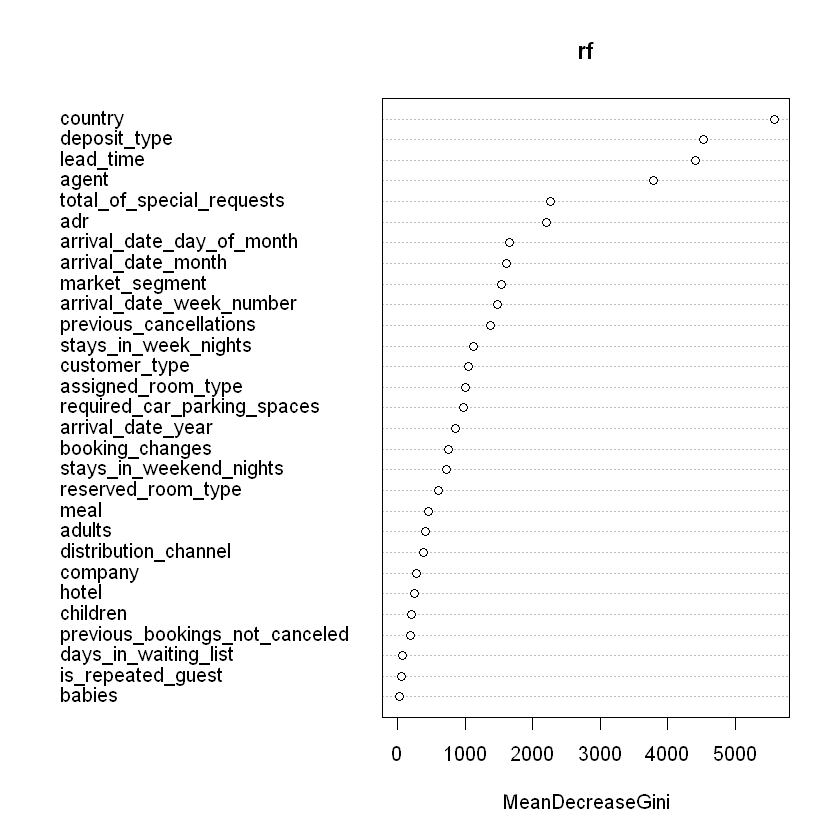

In [80]:
varImpPlot(rf)


# Data Visualization

### Which hotel has more bookings?

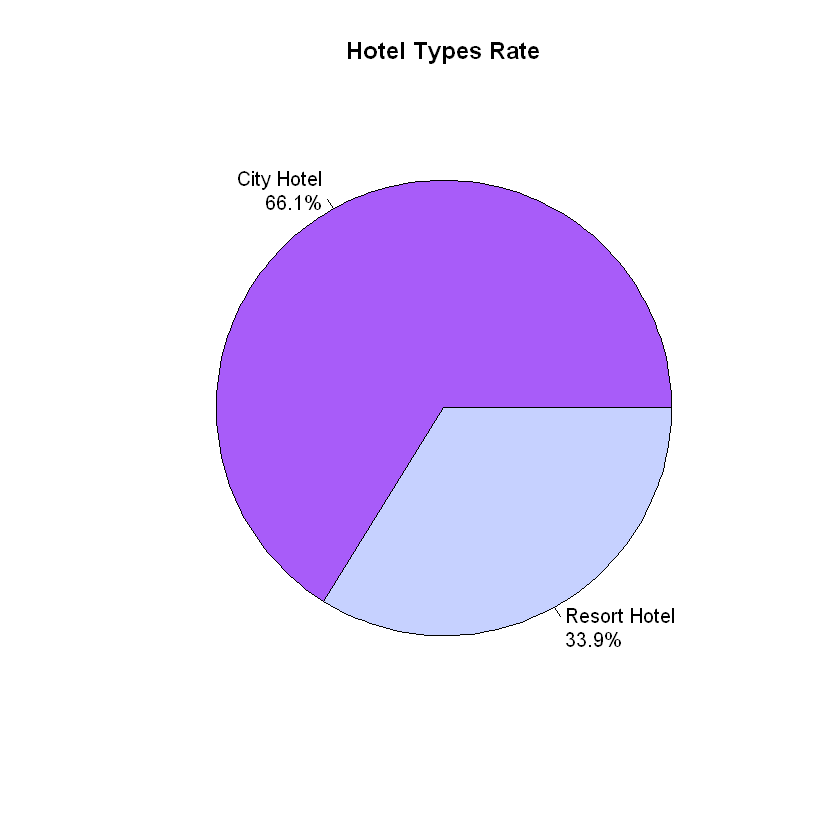

In [81]:
hotel <- table(data$hotel)
hotel_types <- c("City Hotel", "Resort Hotel")

pie_percent<- paste(hotel_types, round(100*hotel/sum(hotel), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(hotel, main = "Hotel Types Rate", labels=pie_percent, col = colors)

The figure shows that City hotel has much more bookings in the period
between the 1st of July of 2015 and the 31st of August 2017

### How likely are guests to cancel their booking in both hotels?

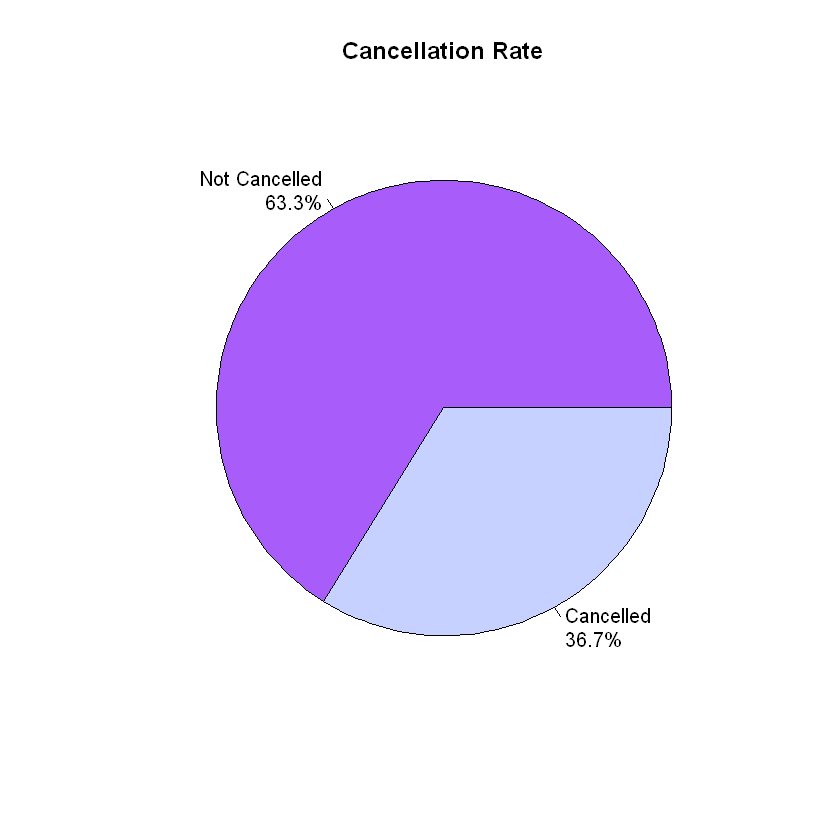

In [82]:
cancel <- table(data$is_canceled)
cancel_label <- c("Not Cancelled", "Cancelled")

pie_percent<- paste(cancel_label, round(100*cancel/sum(cancel), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(hotel, main = "Cancellation Rate", labels=pie_percent, col = colors)

More than one third of the bookings are being cancelled

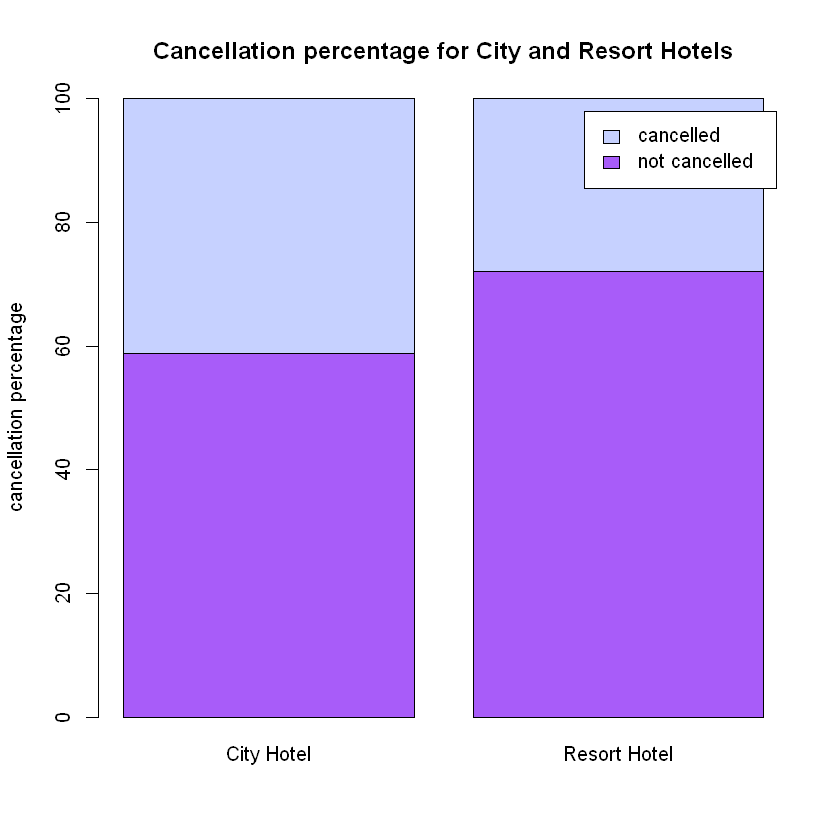

In [83]:
labels <- c("not cancelled", "cancelled")

hotel_cancel <- t(prop.table(table(data$hotel, data$is_canceled), margin = 1)*100)

barplot(hotel_cancel, main = "Cancellation percentage for City and Resort Hotels", 
        , ylim= c(0,100), ylab = "cancellation percentage", legend.text = labels, col = colors)

Most of the Cancellations happen in City hotel which has about 42% cancellations of all its bookings

### Which month has the highest booking rate for each hotel? 


  Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec 
 5758  7886  9607 11008 11418 10771 12158 13503 10132 10794  6594  6512 


 Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec 
3635 4847 6320 7435 8008 7764 7641 8669 7066 7304 4198 3933 

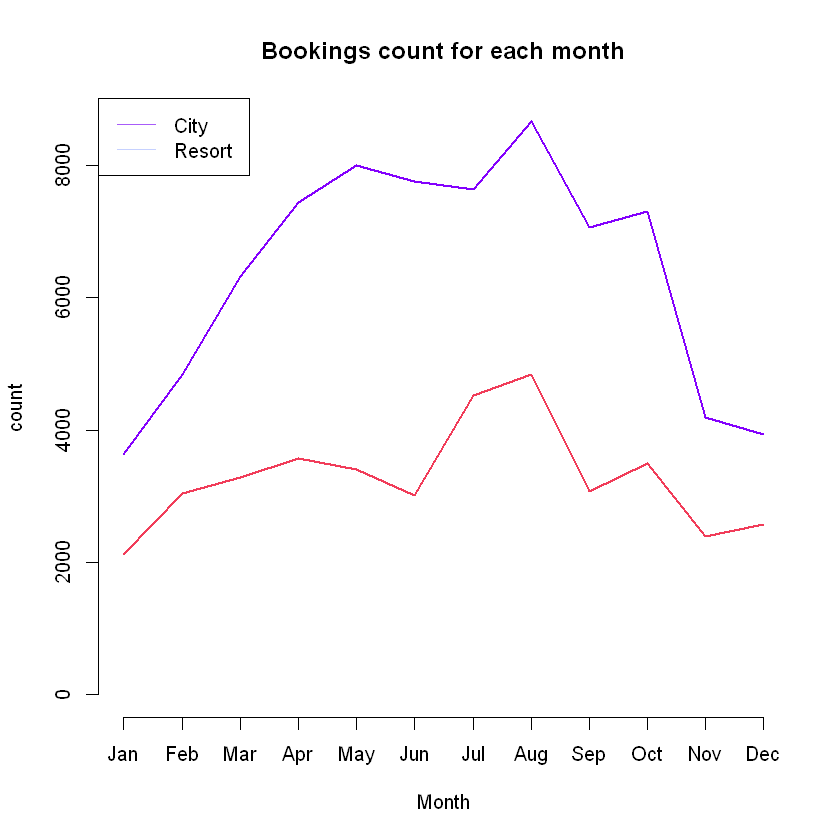

In [84]:
hotel_month <- table(data$hotel, data$arrival_date_month)
table(data$arrival_date_month)
city_month = table(data[data$hotel=='City Hotel',]$arrival_date_month)
resort_month = table(data[data$hotel=='Resort Hotel',]$arrival_date_month)
city_month
plot(city_month, xlab = "Month", ylab = "count", main = "Bookings count for each month", type="l", col = "#8300fd")
lines(resort_month, col = red, type="l")
legend("topleft", legend=c("City", "Resort"),
       col=colors, lty=c(1,1))

As the figure shows, the two hotels reach their highest booking rate in the summer especially in August  
and their lowest booking rate comes between December and January.  
The changes in the two graph show that they almost have the same ups and downs but city hotel has higher rate all the time.


### How does meal choice affect the guest probability of cancellation?
It might be strange but this experiment shows that the people who order the full board meal  
are more likely to cancel their booking and the people who don't order any meal are more  
likely not to cancel

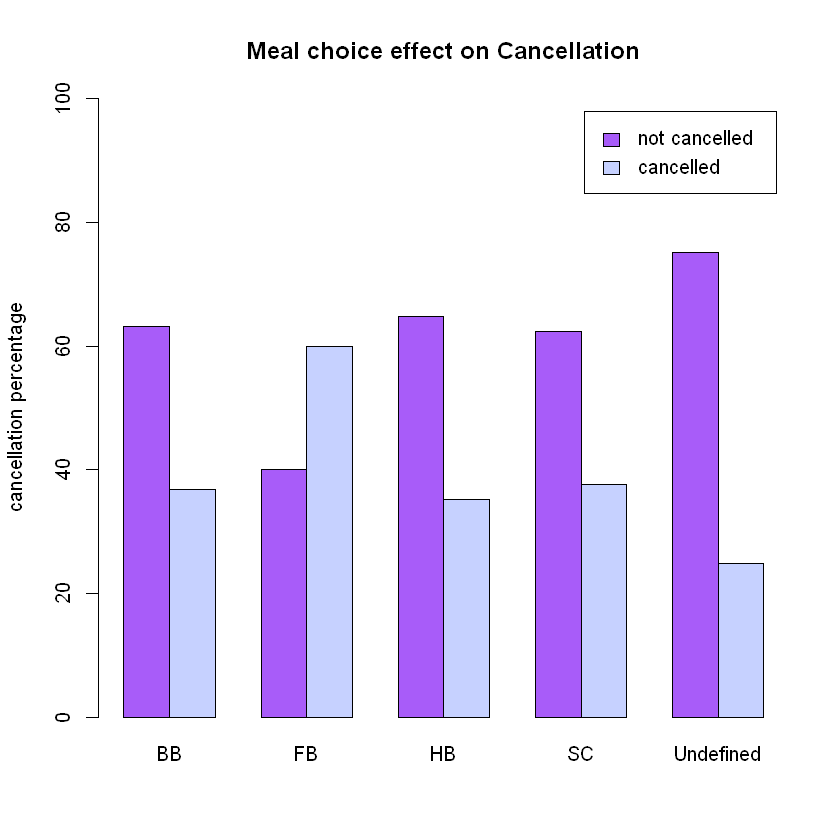

In [85]:
labels <- c("not cancelled", "cancelled")

mean_cancel <- t(prop.table(table(data$meal, data$is_canceled), margin = 1) * 100)

barplot(mean_cancel, beside = T, main = "Meal choice effect on Cancellation", 
        ylab = "cancellation percentage", ylim = c(0,100), legend.text = labels, col=colors)
# barplot(mean_cancel[, -c(2, 5)], legend.text = labels, col=colors)
# barplot(mean_cancel[, c(2, 5)], legend.text = labels, col=colors)

### How many repeat guests does each hotel have?

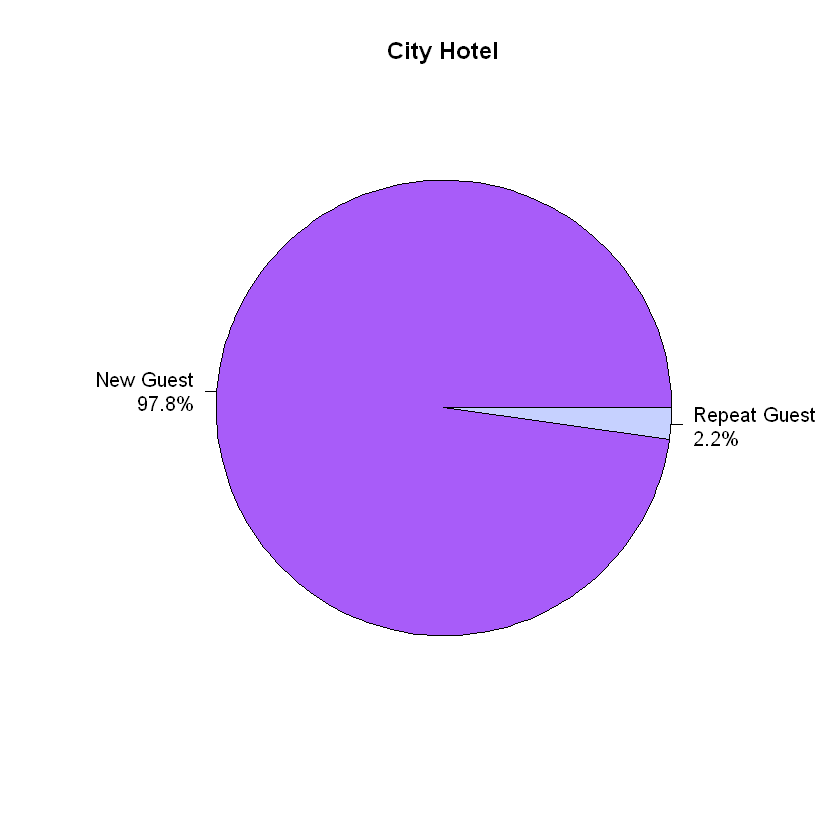

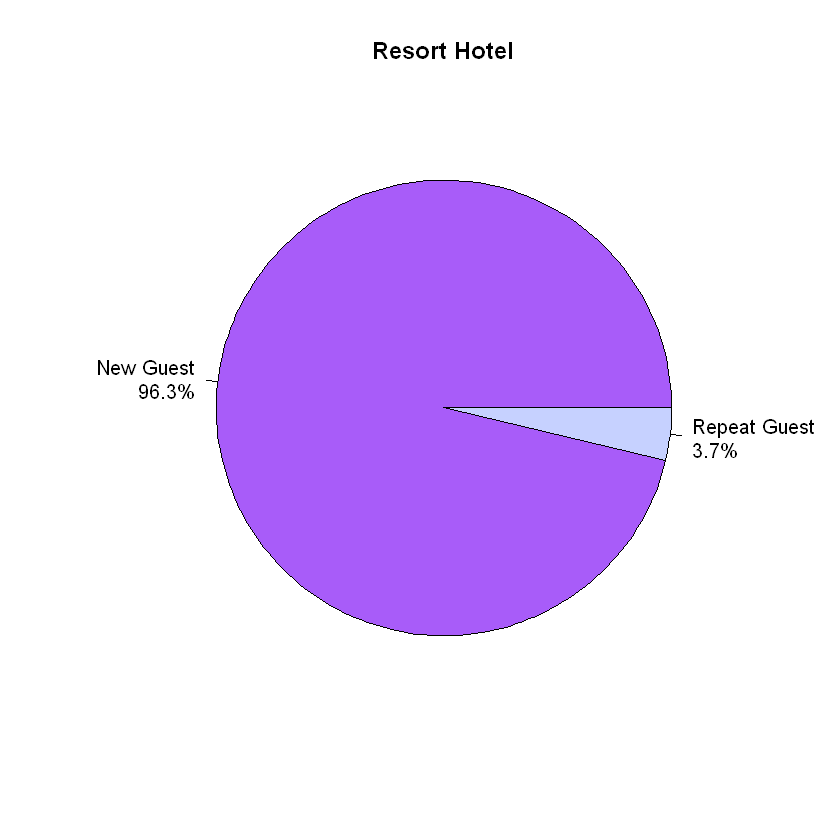

In [86]:
hotel_repeted <- table(data$is_repeated_guest, data$hotel)

repeat_city <- table(data[data$hotel == "City Hotel",]$is_repeated_guest)
repeat_resort <- table(data[data$hotel == "Resort Hotel",]$is_repeated_guest)

repeat_labels <- c("New Guest","Repeat Guest")

pie_percent<- paste(repeat_labels, round(100*repeat_city/sum(repeat_city), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(repeat_city, labels=pie_percent, main = "City Hotel", col = colors)

pie_percent<- paste(repeat_labels, round(100*repeat_resort/sum(repeat_resort), 1), sep="\n") 
pie_percent<- paste(pie_percent, "%", sep="") 
pie(repeat_resort, labels=pie_percent, main = "Resort Hotel", col = colors)

 It's clear that most of the guests of the two hotels don't book in them again and  
 only less than 4% return back to the hotels.  
 So, the hotels should seach for the reasons behind that.

### How many times do the repeat guests come back to each hotel?

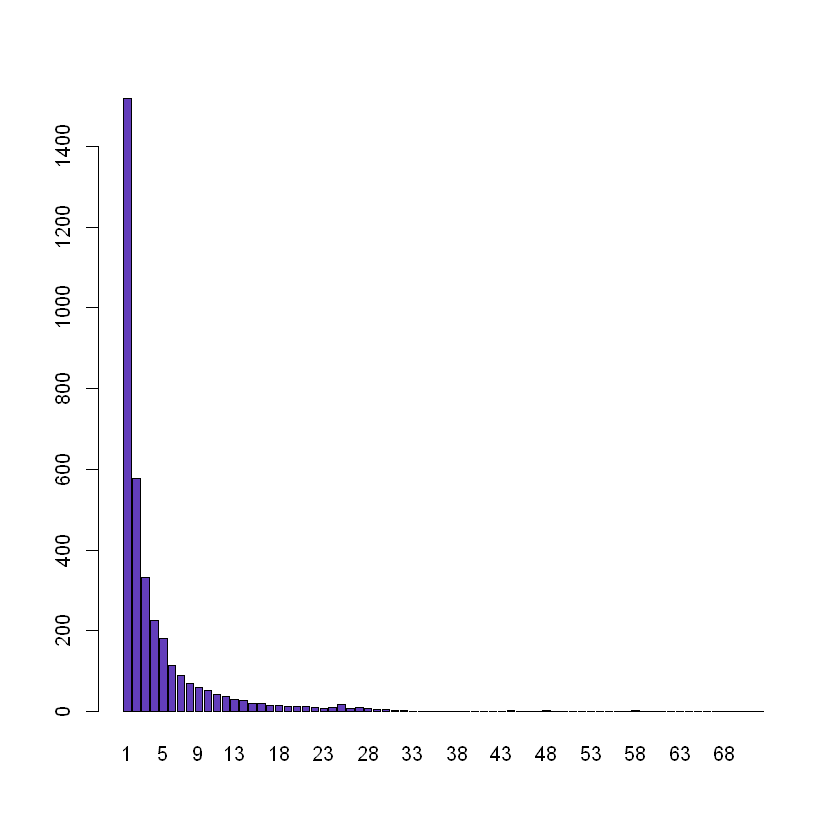

In [87]:
barplot(table(data$previous_bookings_not_canceled)[-1], col = c(purple))

Most of the repeat guests have only one previous visit and  
the number decreases with increasing the number of visits

### Which month has the highest cancellations?

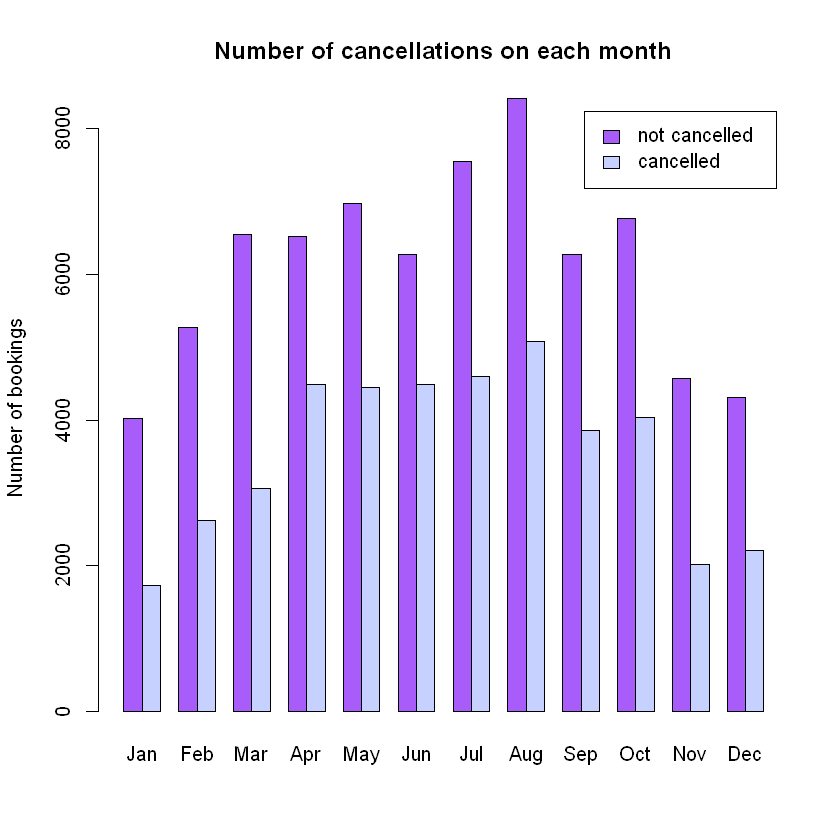

In [88]:
labels <- c("not cancelled", "cancelled")

month_cancel <- table(data$is_canceled, data$arrival_date_month)

barplot(month_cancel, beside = T, main = "Number of cancellations on each month",
        ylab = "Number of bookings",legend.text = labels, col = colors)


Since August is the highest in the bookings, it's also the highest one in cancellation.  
It's also obvious that the cancellations increase in the summer and decrease in the winter.  
January has the lowest number of cancellations.

### Where are the guests from?

  AUT    CN   CHE   USA   NLD   BRA   BEL   IRL   ITA   DEU   ESP OTHER   FRA 
 1256  1267  1720  2066  2094  2212  2334  3363  3746  7016  8528  9728 10350 
  GBR   PRT 
11868 46223 


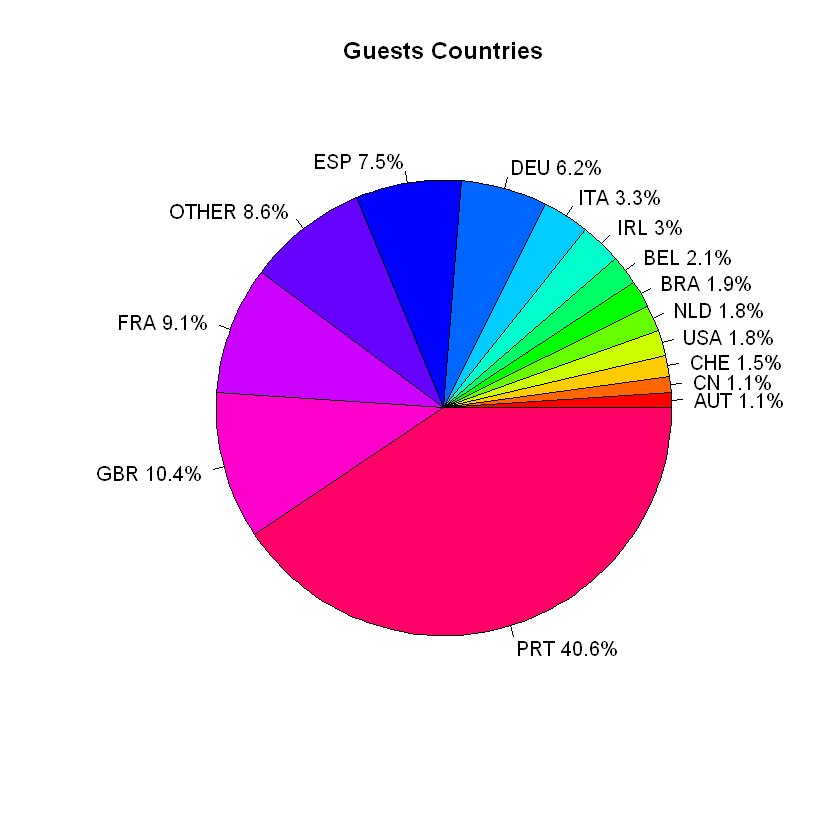

In [92]:
th = 1200
countries = table(data$country)
filtered_countries = countries[countries > th]
filtered_countries["OTHER"] = sum(countries[countries <= th])
filtered_countries = sort(filtered_countries)
print(filtered_countries)

labels = names(filtered_countries)

pie_percent<- paste(labels, round(100*filtered_countries/sum(filtered_countries), 1), sep=" ") 
pie_percent<- paste(pie_percent, "%", sep="")

pie(filtered_countries, main = "Guests Countries", labels=pie_percent, col = rainbow(length(filtered_countries)))

The guests come from many different countries, but most of them come from Portuguese which is the country of the hotels.

### Does assigning a different room type than the reserved one affect the chance of cancellation?
Sometimes the assigned room type differs from the reserved room type due to   
hotel operation reasons (e.g. overbooking) or by customer request.

In [ ]:
room_types = c("A", "B", "C", "D", "E", "F", "G", "H", "I", "K","L", "P")
f1 = factor(data$assigned_room_type, levels = room_types)
f2 = factor(data$reserved_room_type, levels = room_types)


labels <- c("not cancelled", "cancelled")

room_cancel <- prop.table(table(f1 == f2, data$is_canceled), margin=1)*100
rownames(room_cancel) = c("Different", "Same")
room_cancel <- t(room_cancel)

barplot(room_cancel, main = "Assigned Room Type Vs Reserved Room Type",
        ylab = "cancellation percentage",legend.text = labels, col = colors)

Unexpectedly, The guests who are assigned a room type different than the reserved one are  more likely not to cancel the booking.  
This can be because some of the differences were by the customers' requests and not all of them due to overbooking.

### What is the effect of the Deposit type on the likelihood of cancellation?

In [ ]:
labels <- c("not cancelled", "cancelled")

deposit_cancellation <- t(prop.table(table(data$deposit_type, data$is_canceled), margin=1)*100)
deposit_cancellation

barplot(deposit_cancellation, beside = T, ylim = c(0,100),
        main = "Cancellations based on Deposit Type",ylab = "cancellation percentage",legend.text = labels, col = colors)


Another unusual pattern in the data, The figure shows that almost all the people that made a deposit  
in the value of the total stay cost (Non Refund) cancel their bookings.

### How many nights do the guests stay in each hotel?

In [ ]:
labels <- c("City Hotel", "Resort Hotel")


total_nights = data$stays_in_weekend_nights + data$stays_in_week_nights
hotel_nights = prop.table(table(total_nights, data$hotel), margin=2)*100
hotel_nights = t(hotel_nights)

barplot(hotel_nights, beside = T, ylim = c(0,30), main = "Total nights at the hotel",
        xlab = 'Total Nights', ylab = 'bookings percentage', legend.text = labels, col = colors)

Most of the guests book one or two or three nights in the two hotels.